In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ダミーデータの生成
np.random.seed(42)
time_steps = 1000
x = np.arange(time_steps)
y = np.sin(x * 0.01) + np.random.normal(scale=0.1, size=time_steps)  # サイン波にノイズを加えたデータ

# データフレームの作成
data = pd.DataFrame({'x': x, 'y': y})
print(data)

# 特徴量とラベルに分割
X = data['x'].values.reshape(-1, 1)  # 1次元の特徴量
y = data['y'].values  # 予測する数値
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       x         y
0      0  0.049671
1      1 -0.003827
2      2  0.084768
3      3  0.182298
4      4  0.016574
..   ...       ...
995  995 -0.529515
996  996 -0.330263
997  997 -0.454524
998  998 -0.584250
999  999 -0.478345

[1000 rows x 2 columns]


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# データセットとデータローダーの作成
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [5]:
class TransformerRegressor(nn.Module):
    def __init__(self):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(1, 64)  # 1次元の特徴量を64次元に変換
        self.transformer = nn.Transformer(d_model=64, nhead=4, num_encoder_layers=3)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_length=1, features=64) に変換
        x = x.unsqueeze(1)  # (batch_size, seq_length=1, features=64) に変換
        x = self.transformer(x, x)  # エンコーダーのみ使用
        x = x.mean(dim=1)  # バッチの平均を取る
        return self.fc(x)

model = TransformerRegressor()


/root/miniconda3/envs/my-env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [6]:
# 訓練の準備
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 訓練
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/100], Loss: 0.3341
Epoch [10/100], Loss: 0.3443
Epoch [20/100], Loss: 0.4708
Epoch [30/100], Loss: 0.4393
Epoch [40/100], Loss: 0.5850
Epoch [50/100], Loss: 0.4331
Epoch [60/100], Loss: 0.4682
Epoch [70/100], Loss: 0.5804
Epoch [80/100], Loss: 0.6372
Epoch [90/100], Loss: 0.2989


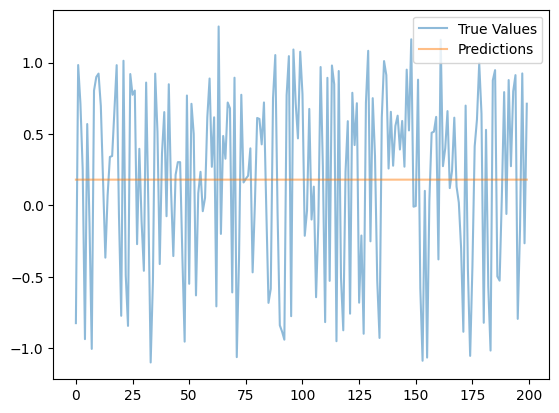

In [7]:
model.eval()
with torch.no_grad():
    predictions = []
    true_values = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.append(outputs.numpy())
        true_values.append(batch_y.numpy())

predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# 結果の表示
import matplotlib.pyplot as plt

plt.plot(true_values, label='True Values', alpha=0.5)
plt.plot(predictions, label='Predictions', alpha=0.5)
plt.legend()
plt.show()